In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import glob
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import glob
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class IMUDataset(Dataset):
    """Dataset for IMU time series data with sliding windows"""

    def __init__(self, sequences, labels):
        self.sequences = torch.FloatTensor(sequences)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

class FOGClassifier(nn.Module):
    """CNN-LSTM model for FOG classification"""

    def __init__(self, input_channels=6, sequence_length=256, num_classes=3, dropout_rate=0.3):
        super(FOGClassifier, self).__init__()

        # 1D CNN layers for feature extraction
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2) # Output length: sequence_length / 2

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2) # Output length: (sequence_length / 2) / 2 = sequence_length / 4

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2) # Output length: (sequence_length / 4) / 2 = sequence_length / 8

        # Calculate the input size for the LSTM based on the sequence_length
        lstm_input_size = 256 # Number of features from the last CNN layer
        lstm_sequence_length = sequence_length // 8 # Length after 3 pooling layers

        self.lstm = nn.LSTM(lstm_input_size, 128, batch_first=True, dropout=dropout_rate if dropout_rate > 0 else 0)

        # Classification head
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Input: [batch_size, sequence_length, channels]
        # Transpose for Conv1d: [batch_size, channels, sequence_length]
        x = x.transpose(1, 2)

        # CNN feature extraction
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        # Transpose back for LSTM: [batch_size, sequence_length_after_pooling, features]
        x = x.transpose(1, 2)

        # LSTM
        lstm_out, (hidden, cell) = self.lstm(x)

        # Use the last output for classification
        x = lstm_out[:, -1, :]  # [batch_size, hidden_size]

        # Classification
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def load_csv_data(data_dir='backend/data'):
    """Load all CSV files and combine them"""
    csv_files = glob.glob(os.path.join(data_dir, "session_*.csv"))

    if not csv_files:
        print(f"No CSV files found in {data_dir}")
        return None

    all_data = []
    print(f"Loading {len(csv_files)} CSV files...")

    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            all_data.append(df)
            print(f"Loaded {csv_file}: {len(df)} samples")
        except Exception as e:
            print(f"Error loading {csv_file}: {e}")

    if not all_data:
        return None

    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Total combined data: {len(combined_df)} samples")

    return combined_df

def create_sequences(data, sequence_length=256, overlap=0.5):
    """Create sliding window sequences from IMU data"""

    # Extract features and labels
    feature_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
    X = data[feature_cols].values
    y = data['label'].values

    # Create label mapping
    label_map = {'walking': 0, 'standing': 1, 'freezing': 2}
    y_encoded = np.array([label_map.get(label, 1) for label in y])  # Default to standing if unknown

    # Create sequences
    step_size = int(sequence_length * (1 - overlap))
    sequences = []
    labels = []

    for i in range(0, len(X) - sequence_length + 1, step_size):
        sequence = X[i:i + sequence_length]
        # Use the most common label in the window
        window_labels = y_encoded[i:i + sequence_length]
        most_common_label = np.bincount(window_labels).argmax()

        sequences.append(sequence)
        labels.append(most_common_label)

    return np.array(sequences), np.array(labels), label_map

def normalize_data(X_train, X_val, X_test):
    """Normalize the data using training set statistics"""
    # Calculate mean and std across all features and time steps for training set
    mean = np.mean(X_train, axis=(0, 1), keepdims=True)
    std = np.std(X_train, axis=(0, 1), keepdims=True)
    std = np.where(std == 0, 1, std)  # Avoid division by zero

    # Normalize all sets
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    X_test_norm = (X_test - mean) / std

    return X_train_norm, X_val_norm, X_test_norm, {'mean': mean, 'std': std}

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, device='cpu'):
    """Train the model"""
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_data, batch_labels in train_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()

        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total

        scheduler.step(val_loss)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Load best model
    model.load_state_dict(best_model_state)
    print(f'Training completed! Best validation accuracy: {best_val_acc:.2f}%')

    return history

def evaluate_model(model, test_loader, device='cpu'):
    """Evaluate the model on test data"""
    model.eval()
    model.to(device)

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            outputs = model(batch_data)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    return all_predictions, all_labels

def plot_results(history, predictions, labels, label_map):
    """Plot training history and confusion matrix"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Training history
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    # Confusion matrix
    cm = confusion_matrix(labels, predictions)
    class_names = list(label_map.keys())
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax3)
    ax3.set_title('Confusion Matrix')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')

    # Accuracy by class
    accuracy_by_class = []
    for i in range(len(class_names)):
        if cm[i].sum() > 0:
            accuracy_by_class.append(cm[i][i] / cm[i].sum())
        else:
            accuracy_by_class.append(0)

    ax4.bar(class_names, accuracy_by_class)
    ax4.set_title('Accuracy by Class')
    ax4.set_ylabel('Accuracy')
    ax4.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def main():
    """Main training function"""
    print("🚀 FOG Classification Training Started")
    print("="*50)

    # Load data
    data = load_csv_data('backend/data')
    if data is None:
        print("❌ No data found. Make sure you have CSV files in backend/data/")
        return

    # Print data statistics
    print(f"\n📊 Data Statistics:")
    print(f"Total samples: {len(data)}")
    print(f"Label distribution:")
    print(data['label'].value_counts())

    # Create sequences
    sequence_length = 256
    overlap = 0.5
    print(f"\n🔄 Creating sequences with length {sequence_length}...")
    sequences, labels, label_map = create_sequences(data, sequence_length=sequence_length, overlap=overlap)
    print(f"Created {len(sequences)} sequences of length {sequence_length}")
    print(f"Label mapping: {label_map}")

    # Split data
    train_size = int(0.7 * len(sequences))
    val_size = int(0.15 * len(sequences))
    test_size = len(sequences) - train_size - val_size

    X_train = sequences[:train_size]
    y_train = labels[:train_size]
    X_val = sequences[train_size:train_size + val_size]
    y_val = labels[train_size:train_size + val_size]
    X_test = sequences[train_size + val_size:]
    y_test = labels[train_size + val_size:]

    print(f"\n📊 Dataset split:")
    print(f"Training: {len(X_train)} sequences")
    print(f"Validation: {len(X_val)} sequences")
    print(f"Test: {len(X_test)} sequences")

    # Normalize data
    X_train_norm, X_val_norm, X_test_norm, norm_params = normalize_data(X_train, X_val, X_test)

    # Create datasets and dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n🖥️ Using device: {device}")

    model = FOGClassifier(
        input_channels=6,
        sequence_length=sequence_length,
        num_classes=3,
        dropout_rate=0.3
    )

    print(f"\n🏗️ Model Architecture:")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    # Train model
    print(f"\n🎯 Starting training...")
    history = train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, device=device)

    # Evaluate on test set
    print(f"\n📊 Evaluating on test set...")
    predictions, test_labels = evaluate_model(model, test_loader, device)

    # Calculate metrics
    accuracy = accuracy_score(test_labels, predictions)
    print(f"\n✅ Test Results:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"\nDetailed Classification Report:")
    print(classification_report(test_labels, predictions, target_names=list(label_map.keys())))

    # Plot results
    plot_results(history, predictions, test_labels, label_map)

    # Save model
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = f'fog_classifier_{timestamp}.pth'

    torch.save({
        'model_state_dict': model.state_dict(),
        'label_map': label_map,
        'normalization_params': norm_params,
        'model_config': {
            'input_channels': 6,
            'sequence_length': sequence_length,
            'num_classes': 3,
            'dropout_rate': 0.3
        }
    }, model_path)

    print(f"\n💾 Model saved as: {model_path}")
    print(f"🎉 Training completed successfully!")

🚀 FOG Classification Training Started
Loading 4 CSV files...
Loaded backend/data/session_20250621_185016.csv: 12363 samples
Loaded backend/data/session_20250621_185106.csv: 12075 samples
Loaded backend/data/session_20250621_194749.csv: 24452 samples
Loaded backend/data/session_20250621_185600.csv: 19357 samples
Total combined data: 68247 samples

📊 Data Statistics:
Total samples: 68247
Label distribution:
label
walking     26997
freezing    22233
standing    19017
Name: count, dtype: int64

🔄 Creating sequences...
Created 1065 sequences of length 128
Label mapping: {'walking': 0, 'standing': 1, 'freezing': 2}

📊 Dataset split:
Training: 745 sequences
Validation: 159 sequences
Test: 161 sequences

🖥️ Using device: cpu

🏗️ Model Architecture:
Total parameters: 349,379

🎯 Starting training...
Epoch [0/100] - Train Loss: 0.5799, Train Acc: 85.77% - Val Loss: 0.1339, Val Acc: 97.48%
Epoch [10/100] - Train Loss: 0.1358, Train Acc: 96.91% - Val Loss: 0.1338, Val Acc: 95.60%
Epoch [20/100] - T

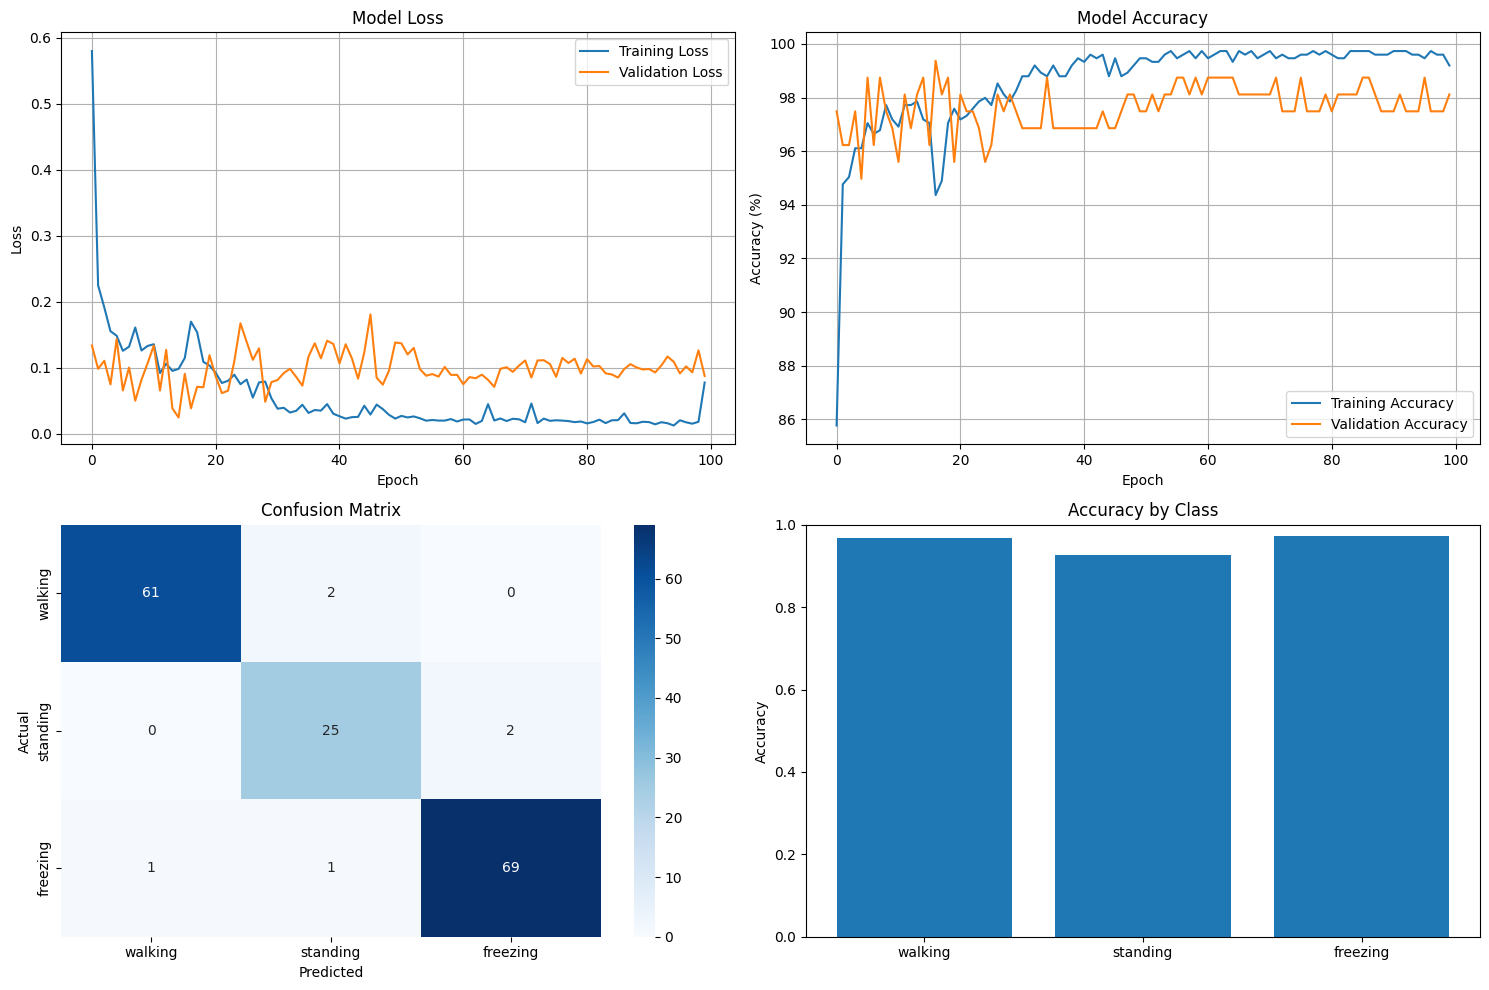


💾 Model saved as: fog_classifier_20250622_043618.pth
🎉 Training completed successfully!


In [12]:

if __name__ == "__main__":
    main()